# COMPAS Bias Analiz Raporu

Bu notebook, COMPAS risk değerlendirme algoritmasındaki olası yanlılıkları (bias) analiz eder.

## 1. Kütüphaneler ve Veri Yükleme

Gerekli kütüphaneleri yüklüyoruz ve Kaggle üzerinden veri setini indiriyoruz.

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import shutil

# Mevcut çalışma dizini
current_dir = os.getcwd()
# Hedef data klasörü
target_dir = os.path.join(current_dir, 'compass_data')

# Download latest version
print("Dataset indiriliyor/kontrol ediliyor...")
path = kagglehub.dataset_download("danofer/compass")
print("KaggleHub Path:", path)

# Hedef klasör yoksa oluştur
if not os.path.exists(target_dir):
    os.makedirs(target_dir)

# Dosyaları kopyala
print(f"Dosyalar {target_dir} klasörüne kopyalanıyor...")
copied_files = []
for file_name in os.listdir(path):
    full_file_name = os.path.join(path, file_name)
    if os.path.isfile(full_file_name):
        shutil.copy(full_file_name, target_dir)
        copied_files.append(file_name)
        print(f"Kopyalandı: {file_name}")

print("\n--- İşlem Tamamlandı ---")
print(f"Veri seti dosyaları şu klasörde: {target_dir}")
print("Dosyalar:", copied_files)

/Users/semihtekay/machine_learning/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Dataset indiriliyor/kontrol ediliyor...
KaggleHub Path: /Users/semihtekay/.cache/kagglehub/datasets/danofer/compass/versions/1
Dosyalar /Users/semihtekay/machine_learning/egitim/compass_data klasörüne kopyalanıyor...
Kopyalandı: cox-violent-parsed_filt.csv
Kopyalandı: compas-scores-raw.csv
Kopyalandı: cox-violent-parsed.csv

--- İşlem Tamamlandı ---
Veri seti dosyaları şu klasörde: /Users/semihtekay/machine_learning/egitim/compass_data
Dosyalar: ['cox-violent-parsed_filt.csv', 'compas-scores-raw.csv', 'cox-violent-parsed.csv']


## 2. Veri Ön İşleme

Dataseti okuyoruz ve analiz için yalnızca gerekli sütunları seçiyoruz.

In [2]:
# ========================================
# ADIM 0: VERİ YÜKLEME
# ========================================
csv_path = os.path.join(target_dir, 'cox-violent-parsed.csv')
df = pd.read_csv(csv_path)

# Gerekli sütunları seç
cols_to_keep = ['sex', 'age', 'age_cat', 'race',
                'juv_fel_count', 'juv_misd_count', 'juv_other_count',
                'priors_count', 'c_charge_degree',
                'days_b_screening_arrest',
                'decile_score', 'score_text', 
                'is_recid']

df = df[cols_to_keep].dropna()

print(f"Veri boyutu: {df.shape}")
print(f"\nIrk dağılımı:\n{df['race'].value_counts()}")

Veri boyutu: (17004, 13)

Irk dağılımı:
race
African-American    9156
Caucasian           5655
Hispanic            1278
Other                804
Asian                 64
Native American       47
Name: count, dtype: int64


## 3. Skor Dağılım Analizi

Farklı ırk grupları arasındaki ortalama risk skorlarını ve genel skor dağılımını inceliyoruz.

In [ ]:
# ========================================
# ADIM 1: Skor Dağılımı (Hangi ırk ne alıyor?)
# ========================================
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df.groupby('race')['decile_score'].mean().plot(kind='bar')
plt.title('Ortalama Risk Skoru (Irklar Arası)')
plt.ylabel('Ortalama Skor')

plt.subplot(1, 2, 2)
sns.boxplot(data=df, x='race', y='decile_score')
plt.title('Skor Dağılımı')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. False Positive/Negative Rate Analizi

Algoritmanın hata türlerini (suçsuza suçlu deme vs. suçluya suçsuz deme) ırklara göre karşılaştırıyoruz.

=== HATA ORANLARI KARŞILAŞTIRMASI ===
               race       FPR       FNR
0             Other  0.121649  0.742947
1  African-American  0.452848  0.326973
2         Caucasian  0.217541  0.545084
3          Hispanic  0.197995  0.609603
4             Asian  0.111111  0.421053
5   Native American  0.166667  0.000000


<Figure size 1000x600 with 0 Axes>

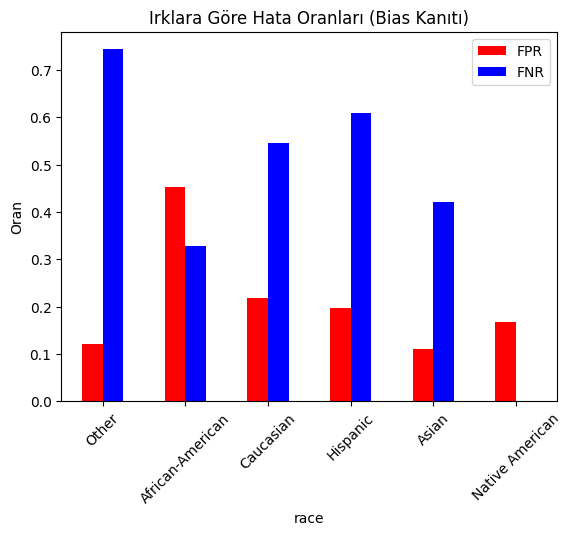

In [6]:
# 1. Fonksiyonu tanımla, iki parametre alsın: tüm veri (data) ve hesaplanacak ırk (race_name)
def calculate_confusion_metrics(data, race_name):
    
    # 2. Veriyi filtrele: Sadece o ırka ait satırları alıp kopyala
    race_data = data[data['race'] == race_name].copy()
    
    # 3. YZ'nin Tahmini (Prediction):
    #    Eğer puan > 5 ise model "Riskli" (1) demiş sayalım. Değilse "Risksiz" (0).
    race_data['predicted_high_risk'] = (race_data['decile_score'] > 5).astype(int)
    
    # 4. Gerçek Durum ve Tahmini değişkenlere ata
    actual = race_data['is_recid']                # Gerçekten suç işlemiş mi?
    predicted = race_data['predicted_high_risk']  # Model "işleyecek" demiş mi?
    
    # 5. Hata Türlerini Say (Burası işin kalbi)
    #    TP (Doğru Bildi): Model 'Suçlu' dedi, Adam 'Suçlu' çıktı.
    tp = ((predicted == 1) & (actual == 1)).sum()
    
    #    FP (Masumu Yaktı): Model 'Suçlu' dedi, Adam 'Suçsuz' çıktı. (BİAS BURADA ÇIKACAK)
    fp = ((predicted == 1) & (actual == 0)).sum()
    
    #    TN (Doğru Bildi): Model 'Suçsuz' dedi, Adam 'Suçsuz' çıktı.
    tn = ((predicted == 0) & (actual == 0)).sum()
    
    #    FN (Suçluyu Kaçırdı): Model 'Suçsuz' dedi, Adam 'Suçlu' çıktı.
    fn = ((predicted == 0) & (actual == 1)).sum()
    
    # 6. Oranları Hesapla (Matematik kısmı)
    #    FPR (False Positive Rate): Masumların yüzde kaçına "Suçlu" denmiş?
    fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    
    #    FNR (False Negative Rate): Suçluların yüzde kaçına "Suçsuz" denmiş?
    fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
    
    # 7. Sonuçları sözlük (dictionary) olarak döndür
    return {
        'race': race_name,
        'FPR': fpr,
        'FNR': fnr,
        'TP': tp, 'FP': fp, 'TN': tn, 'FN': fn
    }
    # 8. Verideki benzersiz ırk isimlerini bul
races = df['race'].unique()
results = []

# 9. Her ırk için fonksiyonu çağır ve sonucu listeye ekle
for race in races:
    metrics = calculate_confusion_metrics(df, race)
    results.append(metrics)

# 10. Listeyi tabloya (DataFrame) çevir ki okuması kolay olsun
results_df = pd.DataFrame(results)

# 11. Tabloyu ekrana bas (Özellikle FPR ve FNR sütunlarını göster)
print("=== HATA ORANLARI KARŞILAŞTIRMASI ===")
print(results_df[['race', 'FPR', 'FNR']])

# 12. Grafik çiz (Kırmızı: Yanlış Pozitif, Mavi: Yanlış Negatif)
plt.figure(figsize=(10, 6))
results_df.set_index('race')[['FPR', 'FNR']].plot(kind='bar', color=['red', 'blue'])
plt.title('Irklara Göre Hata Oranları (Bias Kanıtı)')
plt.ylabel('Oran')
plt.xticks(rotation=45)
plt.show()

## 5. Kontrol Değişkenleri ile Analiz

Benzer yaş ve suç geçmişine sahip bireyleri karşılaştırarak, yanlılığın diğer değişkenlerle ilişkisini inceliyoruz.

In [ ]:
# =============================================================================
# MANTIK: "Elma ile Elmayı" Kıyaslamak (Stratification)
# Amacımız: Irksal farkın sebebi "Yaş" veya "Suç Geçmişi" mi yoksa "Algoritma" mı?
# Bunu anlamak için insanları benzer özelliklerine göre küçük gruplara ayıracağız.
# =============================================================================

# 1. ADIM: Grupları (Kutucukları) Tanımla
# Yaş grupları: Genç (en riskli), Orta yaşlar ve Yaşlı olarak böldük.


# Suç geçmişi: Hiç/Az (0-1), Orta (2-5), Çok (6+) sabıkası olanlar.


print("\n=== KONTROL DEĞİŞKENLERİ ANALİZİ (Benzer Gruplar İçinde Fark Var mı?) ===")

# 2. ADIM: Her Bir Kombinasyonu Tek Tek Gez (İç İçe Döngü)
# Önce yaş aralığını seç (örn: 18-25), sonra o yaşın içindeki suç gruplarını gez.
for age_min, age_max in age_groups:
    for priors_min, priors_max in priors_groups:
        
        # 3. ADIM: Alt Kümeyi (Subset) Oluştur
        # Ana tablodan SADECE şu anki yaş ve suç aralığına uyan kişileri çekip ayırıyoruz.
        # Örn: "Hem 18-25 yaş arası olsun HEM DE 0-1 sabıkası olsun."
        subset = df[
            (df['age'] >= age_min) & (df['age'] < age_max) &           # Yaş Filtresi
            (df['priors_count'] >= priors_min) & (df['priors_count'] <= priors_max) # Suç Filtresi
        ]
        
        # 4. ADIM: Yeterli Veri Kontrolü
        # Eğer bu özel grupta 50 kişiden az varsa, ortalama almak istatistiksel olarak yanıltır.
        if len(subset) > 50:
            print(f"\n--- Grup: Yaş {age_min}-{age_max} | Sabıka {priors_min}-{priors_max} (Kişi Sayısı={len(subset)}) ---")
            
            # 5. ADIM: Final Karşılaştırma - Asıl Kanıt Burası
            # Artık şartlar eşit! (Herkes aynı yaş grubunda, herkesin sabıkası benzer).
            # Şimdi bu "eşit şartlar altında" Irkların ortalama puanına bakalım.
            race_scores = subset.groupby('race')['decile_score'].mean()
            print(race_scores)
            
            # DERS NOTU: Eğer burada hala fark çıkıyorsa (ki çıkıyor), 
            # bunun sebebi yaş veya suç geçmişi değildir; Algoritmanın yanlılığıdır.

## 6. İstatistiksel Testler

Gözlemlenen farkların istatistiksel olarak anlamlı olup olmadığını T-Test ve Chi-Square testleri ile doğruluyoruz.

In [ ]:
# ========================================
# ADIM 4: İSTATİSTİKSEL TESTLER
# ========================================
print("\n=== İSTATİSTİKSEL TESTLER ===")

# African-American vs Caucasian karşılaştırması
aa_scores = df[df['race'] == 'African-American']['decile_score']
cauc_scores = df[df['race'] == 'Caucasian']['decile_score']

# T-test
t_stat, p_value = stats.ttest_ind(aa_scores, cauc_scores)
print(f"\nT-Test (African-American vs Caucasian):")
print(f"  Ortalama fark: {aa_scores.mean() - cauc_scores.mean():.2f}")
print(f"  T-statistic: {t_stat:.4f}")
print(f"  P-value: {p_value:.6f}")
print(f"  Anlamlı mı? {'✅ EVET (p < 0.05)' if p_value < 0.05 else '❌ HAYIR'}")

# Chi-square test (Yüksek risk oranları)
df['high_risk'] = (df['decile_score'] > 5).astype(int)
contingency_table = pd.crosstab(df['race'], df['high_risk'])
chi2, p_chi, dof, expected = stats.chi2_contingency(contingency_table)

print(f"\nChi-Square Test (Irk vs Yüksek Risk):")
print(f"  Chi-square: {chi2:.4f}")
print(f"  P-value: {p_chi:.6f}")
print(f"  Anlamlı mı? {'✅ EVET (p < 0.05)' if p_chi < 0.05 else '❌ HAYIR'}")

## 7. Özellik Önemi Analizi

Random Forest modeli kullanarak, tahminlerde en etkili özelliklerin hangileri olduğunu belirliyoruz.

In [ ]:
# ========================================
# ADIM 5: ÖZELLİK ÖNEMİ ANALİZİ
# ========================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

print("\n=== ÖZELLİK ÖNEMİ ANALİZİ ===")

# Kategorik değişkenleri encode et
df_encoded = df.copy()
le_sex = LabelEncoder()
le_race = LabelEncoder()
le_charge = LabelEncoder()

df_encoded['sex'] = le_sex.fit_transform(df_encoded['sex'])
df_encoded['race'] = le_race.fit_transform(df_encoded['race'])
df_encoded['c_charge_degree'] = le_charge.fit_transform(df_encoded['c_charge_degree'])

# Model oluştur
features = ['age', 'sex', 'race', 'priors_count', 'juv_fel_count', 'c_charge_degree']
X = df_encoded[features]
y = df_encoded['is_recid']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Özellik önemleri
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\nÖzellik Önem Sıralaması:")
print(feature_importance)

# Görselleştir
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'], feature_importance['importance'])
plt.xlabel('Önem Skoru')
plt.title('Hangi Özellik Tahmine Ne Kadar Etki Ediyor?')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 8. Özet Rapor

Tüm analizlerin kısa bir özeti.

In [ ]:
# ========================================
# ÖZET RAPOR
# ========================================
print("\n" + "="*60)
print("ÖZET RAPOR: COMPAS BİAS ANALİZİ")
print("="*60)

print(f"\n1. SKOR ORTALAMARI:")
for race in ['African-American', 'Caucasian']:
    if race in df['race'].values:
        avg_score = df[df['race'] == race]['decile_score'].mean()
        print(f"   {race}: {avg_score:.2f}")

print(f"\n2. FALSE POSITIVE RATES:")
for _, row in results_df.iterrows():
    if row['race'] in ['African-American', 'Caucasian']:
        print(f"   {row['race']}: {row['FPR']:.2%}")

print(f"\n3. EN ÖNEMLİ ÖZELLİKLER:")
for _, row in feature_importance.head(3).iterrows():
    print(f"   {row['feature']}: {row['importance']:.4f}")

print(f"\n4. İSTATİSTİKSEL ANLAM:")
print(f"   Irk ve skor arasında anlamlı ilişki var mı? {'✅ EVET' if p_chi < 0.05 else '❌ HAYIR'}")